In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader,TensorDataset,random_split
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import pyplot as plt


class Simulation:
    def __init__(self):        
        self.position=0.3
        #self.position_wobble=0.05
        #self.position_uncertainty=0.1
        self.position_wobble=0.00
        self.position_uncertainty=0.0
        
    def step(self,dec):
        mag,dur=dec
        #input magnitude,duration
        #returns x position output
        
        self.position=self.position+0.4*np.clip(np.sin(mag*np.pi/2),-1,1)*np.sqrt(dur)+np.random.normal(0,self.position_wobble)
        return [ self.position+np.random.normal(0,self.position_uncertainty) ]

In [2]:
from torch.utils.data import Dataset,DataLoader,TensorDataset,random_split
import random

class WeightedLeakyMemory():
    def __init__(self,max_len):
        self.max_len=max_len
        self.experiences=[]
        
    def get_average_weight(self):
        thesum=0
        for x in self.experiences:
            thesum+=x[1]
        return thesum/len(self.experiences)                    
    
    def get_average_inv_weight(self):
        thesum=0
        for x in self.experiences:
            thesum+=1/x[1]
        return thesum/len(self.experiences)                    
        
    def choose_by_inv_weight(self):
        weights=[ x[1] for x in self.experiences]
        return random.choices(self.experiences, weights=weights)[0]
    
    def choose_by_weight(self):
        weights=[ 1/x[1] for x in self.experiences]
        return random.choices(self.experiences, weights=weights)[0]
    
    def forget(self):        
        while len(self.experiences)>self.max_len:
            self.experiences.remove(self.choose_by_weight())
                
    def add_experience(self,experience,weight):
        #your chance of forgetting is propotional to the experience weight
        self.experiences.append([experience,weight])
        self.forget()                                        
        



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

        
class TheThing:
    def __init__(self):        
        self.experience_memory=WeightedLeakyMemory(64)
        self.min_loss=0.0001 #this maps to maximally forgettable
        self.max_loss=.1 #this maps to minimally forgettable
        
        self.decision_mode="random"
        #self.decision_mode="learning"
        self.decision_bounds=[ [-1,1],[0,1] ]  #array of [min,max]
        self.learn_jitter=[0.2,0.2]
        
        hidden_size=4
        #start x, move power, move dur -> new x
        self.motion_predictor=nn.Sequential(nn.Linear(3,hidden_size),
                              nn.Tanh(),
                              nn.Linear(hidden_size,1))
        #start x, end x -> move power, move dur
        self.command_predictor=nn.Sequential(nn.Linear(2,hidden_size),
                                             nn.Tanh(),
                                             nn.Linear(hidden_size,2))   
                                             
        
        #how often to train?  
        #I suppose when the average experience memory weight gets below a certain value?
        self.memory_count_min_train=8
        self.last_train_new_exp=0
        self.memory_invweight_train_trigger=0.01 #     
        
    def experience_to_motionpredictor_tensors(self,memoryexp):
        xs=[]
        ys=[]
        for x in memoryexp:
            xs.append( torch.tensor([ *(x[0][0]),*(x[0][1]) ]).float() )
            ys.append( torch.tensor(x[0][2]).float())
        return torch.stack(xs),torch.stack(ys)

    def loss_to_weight(self,loss):
        return 1/np.clip(loss,self.min_loss,self.max_loss)
        
    def observe(self,last_input_vector,last_decision,this_input_vector):
        #predict target from input, get error
        with torch.set_grad_enabled(False):
            loss_function = torch.nn.MSELoss()
            input_tensor=torch.tensor( [*last_input_vector,*last_decision ]).float()
            prediction=self.motion_predictor(torch.unsqueeze(input_tensor,0))[0]
            loss=(loss_function(prediction,torch.tensor(this_input_vector).float())).item()        
        
        #record in experience_memory
        self.experience_memory.add_experience([last_input_vector,last_decision,this_input_vector],self.loss_to_weight(loss))
        #perhaps train
        #if self.last_train_new_exp>self.memory_count_min_train and self.experience_memory.get_average_inv_weight()>self.memory_invweight_train_trigger:
        if self.last_train_new_exp>self.memory_count_min_train:
            self.train()
            if self.decision_mode=="random":
                self.decision_mode="learning"
            else:
                self.decision_mode="random"
        else:
            self.last_train_new_exp+=1
            #print("not training, avg inv weight: {}".format(self.experience_memory.get_average_inv_weight()))
            #print("should train: {}".format(self.experience_memory.get_average_weight()))        
        
    def decide(self,input_vector):
        #returns vector representing chosen action                
        if self.decision_mode=="random":
            my_decision=[]
            for d in self.decision_bounds:
                my_decision.append(random.uniform(d[0],d[1]))
            return my_decision
        elif self.decision_mode=="learning":            
            a_decision=self.experience_memory.choose_by_inv_weight()[0][1]            
            for i in range(len(a_decision)):
                a_decision[i]+=random.uniform(-self.learn_jitter[i],self.learn_jitter[i])
                a_decision[i]=np.clip(a_decision[i],self.decision_bounds[i][0],self.decision_bounds[i][1])
            return a_decision
            
        else:
            print("error, undefined decision mode")
    
    def train(self):
        print("before: {}".format(self.experience_memory.get_average_inv_weight()))
        inputs,targets=self.experience_to_motionpredictor_tensors(self.experience_memory.experiences)        
        optimizer = optim.Adam(self.motion_predictor.parameters(), lr=0.01)        
        overall_loss=0
        max_epochs=100
        n_epochs_total=0
        #while self.experience_memory.get_average_inv_weight()>memory_invweight_train_trigger and n_epochs_total<max_epochs:
        while n_epochs_total<max_epochs:
            n_epochs=10
            n_epochs_total+=n_epochs
            for epoch in range(n_epochs):                
                    #                    input_batch,target_batch=input_batch.to(device), target_batch.to(device)                                          
                    loss_function = torch.nn.MSELoss()
                    out=self.motion_predictor( inputs )
                    loss=loss_function(out,targets )
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            #now recalculate everything in memory
            with torch.set_grad_enabled(False):
                out=self.motion_predictor( inputs )
                for i in range(len(self.experience_memory.experiences)):
                    self.experience_memory.experiences[i][1]=self.loss_to_weight(loss_function(out[i],targets[i]).item())
        print("after: {}".format(self.experience_memory.get_average_inv_weight()))
        self.last_train_new_exp=0








In [4]:
from tqdm import tqdm
sim=Simulation()
actor=TheThing()

obs_vectors=[]
dec_vectors=[]
nsteps=500
input_vector=sim.step([0,0])
obs_vectors.append(input_vector)
for i in tqdm(range(nsteps)):
    decision=actor.decide(input_vector)
    last_input_vector=input_vector
    input_vector=sim.step(decision)
    actor.observe(last_input_vector,decision,input_vector)    
    dec_vectors.append(decision)
    obs_vectors.append(input_vector)
    
    
obs_vectors=np.array(obs_vectors)
dec_vectors=np.array(dec_vectors)
    
#print(actor.experience_memory.experiences)

  4%|███▏                                                                            | 20/500 [00:00<00:03, 137.35it/s]

before: 0.0632203726034984
after: 0.008171779651456745
before: 0.0496700678711204
after: 0.00979971334261587
before: 0.018457682099455655


  8%|██████▍                                                                         | 40/500 [00:00<00:03, 141.11it/s]

after: 0.0022181147288426297
before: 0.003186861439414497
after: 0.0037232396028027866
before: 0.004006968369465321
after: 0.0035547699693031605
before: 0.012374632740694407


 16%|████████████▊                                                                   | 80/500 [00:00<00:03, 133.57it/s]

after: 0.004428939939858778
before: 0.006246368356582023
after: 0.003217225087475889
before: 0.0065118293838644595
after: 0.0062106027831639946
before: 0.008439750587410162


 20%|███████████████▊                                                               | 100/500 [00:00<00:03, 130.98it/s]

after: 0.0053893767268091315
before: 0.005644522825234162
after: 0.0042209122409625705
before: 0.005228927956305051
after: 0.003585052159766928
before: 0.002502691496161423


 28%|██████████████████████                                                         | 140/500 [00:01<00:02, 129.72it/s]

after: 0.0033056607456055627
before: 0.0037066004217886075
after: 0.0027628170137713823
before: 0.0018228248568242637
after: 0.0019525268153838629
before: 0.001640563760681653


 32%|█████████████████████████▎                                                     | 160/500 [00:01<00:02, 128.62it/s]

after: 0.0014747331081442104
before: 0.001003719622406425
after: 0.0015629650787568612
before: 0.001392367373973139
after: 0.0012806361882221613
before: 0.0011613818585263294


 40%|███████████████████████████████▌                                               | 200/500 [00:01<00:02, 127.83it/s]

after: 0.001506889439402403
before: 0.0016593652066110738
after: 0.0014334863835250876
before: 0.001130863015027353
after: 0.0014097376245179479
before: 0.0014910463817348503


 44%|██████████████████████████████████▊                                            | 220/500 [00:01<00:02, 127.30it/s]

after: 0.0013596650912306362
before: 0.001977718942897991
after: 0.002292855647104989
before: 0.004444186925687791
after: 0.0034444156247132925
before: 0.002156004344308167


 52%|█████████████████████████████████████████                                      | 260/500 [00:02<00:01, 127.33it/s]

after: 0.002182720769056323
before: 0.001940781162843996
after: 0.0017910313737464097
before: 0.001809775255937166
after: 0.0017009691017367005
before: 0.001490921604439791


 56%|████████████████████████████████████████████▏                                  | 280/500 [00:02<00:01, 127.05it/s]

after: 0.0013819175175594867
before: 0.001351428988240514
after: 0.0013069002969214127
before: 0.002212587532366342
after: 0.0019348556698019822
before: 0.0017087105798196719


 64%|██████████████████████████████████████████████████▌                            | 320/500 [00:02<00:01, 126.36it/s]

after: 0.0021486124276274493
before: 0.002118959925392483
after: 0.0020459338019725697
before: 0.001523333137899681
after: 0.0019591531763722744
before: 0.0021425953793223016


 68%|█████████████████████████████████████████████████████▋                         | 340/500 [00:02<00:01, 126.04it/s]

after: 0.002076760359623586
before: 0.002376966078688565
after: 0.002353680068286667
before: 0.0016000061603464932
after: 0.001435824381492967
before: 0.0012692473689194233


 76%|████████████████████████████████████████████████████████████                   | 380/500 [00:02<00:00, 126.01it/s]

after: 0.0014047161623140713
before: 0.0013409155903395008
after: 0.001267823212801159
before: 0.0009538561911944276
after: 0.0010826037843353338
before: 0.001089537230792303


 80%|███████████████████████████████████████████████████████████████▏               | 400/500 [00:03<00:00, 125.11it/s]

after: 0.0010045657026943448
before: 0.0007271932187459245
after: 0.0008076478429993586
before: 0.0007648932941669046
after: 0.0007217318131453796
before: 0.0006166983698170954


 88%|█████████████████████████████████████████████████████████████████████▌         | 440/500 [00:03<00:00, 125.28it/s]

after: 0.0012648011509289066
before: 0.0008940662265233188
after: 0.0008351590900256272
before: 0.0006601119266522802
after: 0.0007528739577666786
before: 0.0006931389706560368


 92%|████████████████████████████████████████████████████████████████████████▋      | 460/500 [00:03<00:00, 125.61it/s]

after: 0.0006716764496495673
before: 0.0005652267498860966
after: 0.0007886739529001719
before: 0.0005990094267928726
after: 0.0005528027803604345
before: 0.0007274235452237916


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 127.66it/s]

after: 0.0008002348522084504
before: 0.0005230839940773876
after: 0.00047630242246214026
before: 0.00041452491147701934
after: 0.0009821477961129861


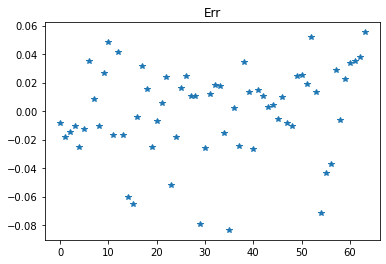

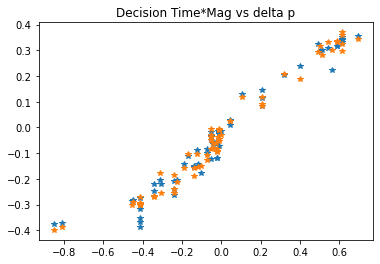

In [5]:
from matplotlib import pyplot as plt
inputs,targets=actor.experience_to_motionpredictor_tensors(actor.experience_memory.experiences)        
out=actor.motion_predictor( inputs ).detach()

fig, ax = plt.subplots()
plt.title("Err")
ax.plot( targets[:,0]-out[:,0],'*')
plt.show()

fig, ax = plt.subplots()
plt.title("Decision Time*Mag vs delta p")
ax.plot( inputs[:,1]*inputs[:,2],targets[:,0]-inputs[:,0],'*')
ax.plot( inputs[:,1]*inputs[:,2],out[:,0]-inputs[:,0],'*')
plt.show()
    


In [6]:

def plot_records(obs_vectors,dec_vectors):
    fig, ax = plt.subplots()
    plt.title("Position")
    ax.plot(obs_vectors[:,0],'*')
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("Decision Mag")
    ax.plot(dec_vectors[:,0],'*')
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("Decision Time")
    ax.plot(dec_vectors[:,1],'*')
    plt.show()
    
    delta_obs=obs_vectors[1:,0]-obs_vectors[:-1,0]
    combo_dec=0.4*np.clip(np.sin(dec_vectors[:,0]*np.pi/2),-1,1)*np.sqrt(dec_vectors[:,1])
    fig, ax = plt.subplots()
    plt.title("Decision Time*Mag vs delta p")
    #ax.plot(dec_vectors[:-1,1]*dec_vectors[:-1,0],obs_vectors[1:,0]-obs_vectors[:-1,0],'*')
    ax.plot(combo_dec,delta_obs,'*')
    ax.plot(dec_vectors[:,0]*dec_vectors[:,1],delta_obs,'*')
    plt.show()

def plot_experiences(actor):
    dataset=MotionPredictorDataset(actor.experience_memory)
    xs=[]
    ys=[]
    for i in range(len(dataset)):
        x,y=dataset[i]
        #print(x)
        #print(y)
        xs.append(x)
        ys.append(y)
    xs=torch.stack(xs)
    ys=torch.stack(ys)
    
    fig, ax = plt.subplots()
    plt.title("Decision Time*Mag vs delta p")
    ax.plot( xs[:,1]*xs[:,2],ys[:,0]-xs[:,0],'*')
    plt.show()
    

